In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Data.zip to Data.zip
User uploaded file "Data.zip" with length 53962736 bytes


In [ ]:
from zipfile import ZipFile
file_name = "Data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
import numpy as np
import keras.optimizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
import tensorflow as tf 
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt


In [ ]:
train_dir = 'Data/train'
test_dir = 'Data/test'
       

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 25102 images belonging to 5 classes.
Found 6236 images belonging to 5 classes.


In [ ]:
training_set.class_indices
print(training_set.image_shape)

(48, 48, 1)


In [ ]:
def get_model(input_size, classes=5):
    model = tf.keras.models.Sequential()   
    model.add(Conv2D(32,kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))
 
    opt = tf.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

    #Compliling the model
    model.compile(optimizer=opt, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model
fernet = get_model((48,48,1), 5)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [ ]:

chk_path = 'face_recognition.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]


In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size


hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
392/392 [==============================] - ETA: 0s - loss: 4.1098 - accuracy: 0.3063
Epoch 1: val_loss improved from inf to 7.40364, saving model to face_recognition.h5
392/392 [==============================] - 36s 62ms/step - loss: 4.1098 - accuracy: 0.3063 - val_loss: 7.4036 - val_accuracy: 0.2125 - lr: 1.0000e-04
Epoch 2/60
392/392 [==============================] - ETA: 0s - loss: 3.3280 - accuracy: 0.3534
Epoch 2: val_loss improved from 7.40364 to 3.05220, saving model to face_recognition.h5
392/392 [==============================] - 22s 56ms/step - loss: 3.3280 - accuracy: 0.3534 - val_loss: 3.0522 - val_accuracy: 0.3998 - lr: 1.0000e-04
Epoch 3/60
392/392 [==============================] - ETA: 0s - loss: 2.8587 - accuracy: 0.3817
Epoch 3: val_loss improved from 3.05220 to 2.59335, saving model to face_recognition.h5
392/392 [==============================] - 23s 58ms/step - loss: 2.8587 - accuracy: 0.3817 - val_loss: 2.5933 - val_accuracy: 0.4170 - lr: 1.0000e-04
Ep

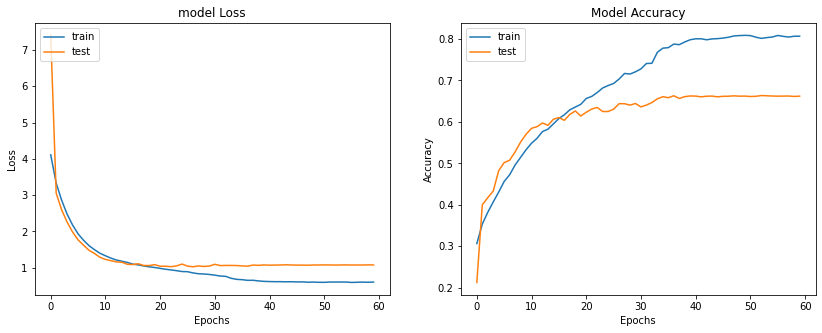

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
fernet.save('face_recognition.h5')

In [ ]:
from keras.models import load_model
emotion_model = load_model('face_recognition.h5')

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

98/98 [==============================] - 2s 24ms/step - loss: 1.0737 - accuracy: 0.6623
final train accuracy = 87.39 , validation accuracy = 66.23


Confusion Matrix
[[ 613  614 1156  813  799]
 [ 628  638 1195  852  784]
 [1161 1090 2099 1508 1357]
 [ 735  800 1489 1010  931]
 [ 722  707 1418 1035  948]]
Classification Report
              precision    recall  f1-score   support

       angry       0.16      0.15      0.16      3995
        fear       0.17      0.16      0.16      4097
       happy       0.29      0.29      0.29      7215
     neutral       0.19      0.20      0.20      4965
         sad       0.20      0.20      0.20      4830

    accuracy                           0.21     25102
   macro avg       0.20      0.20      0.20     25102
weighted avg       0.21      0.21      0.21     25102



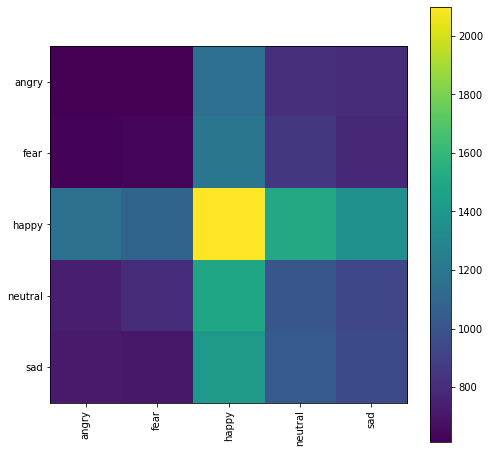

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[168 139 260 212 179]
 [147 141 296 235 205]
 [262 277 511 413 311]
 [215 169 337 265 247]
 [186 165 364 279 253]]
Classification Report
              precision    recall  f1-score   support

       angry       0.17      0.18      0.17       958
        fear       0.16      0.14      0.15      1024
       happy       0.29      0.29      0.29      1774
     neutral       0.19      0.21      0.20      1233
         sad       0.21      0.20      0.21      1247

    accuracy                           0.21      6236
   macro avg       0.20      0.20      0.20      6236
weighted avg       0.21      0.21      0.21      6236



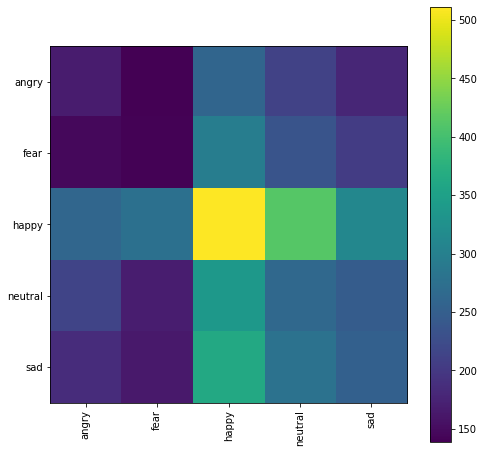

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
def emotion_analysis(emotions):
    objects = ('angry',  'fear', 'happy', 'sad', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [28]:
import cv2
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN
  
def facecrop(image):
    faceboxes = []
    faces_list = []
    imag =cv2.imread(image)
    img = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    for i in range(len(detector.detect_faces(img))):
        faceboxes.append(detector.detect_faces(img)[i]['box'])
    face = np.array(faceboxes)
    if np.any(face):
        for (x, y, w, h) in face:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
            face = img[y:y + h, x:x + w]
            cv2.imwrite('face.jpg', face)
            resized_face = cv2.resize(face, (48, 48))
            gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)
            faces_list.append(gray_face)
        return faces_list


36


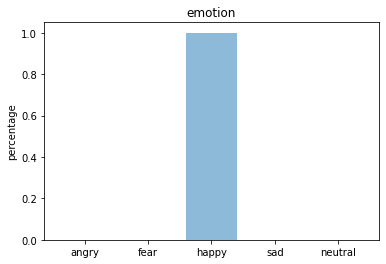

Happy
36


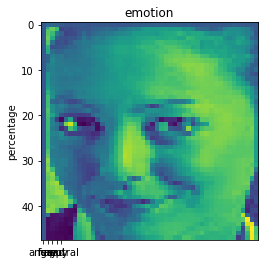

Fear
36


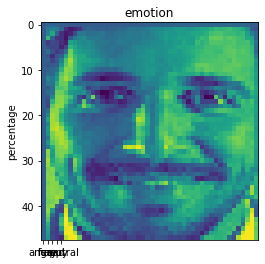

Happy
36


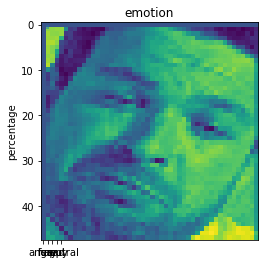

Fear
36


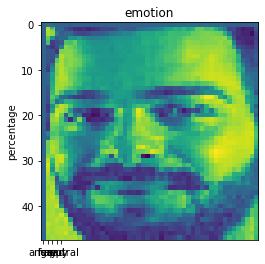

Happy
36


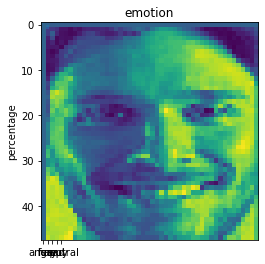

Fear
36


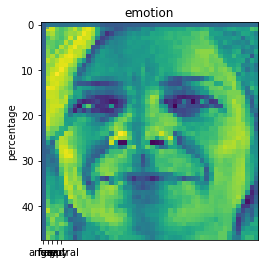

Fear
36


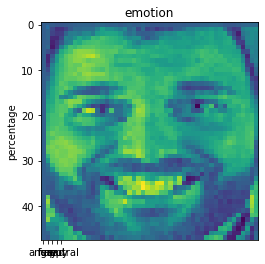

Fear
36


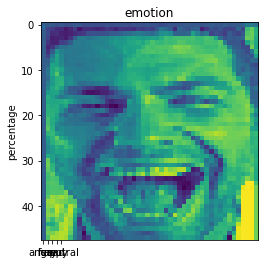

Angry
36


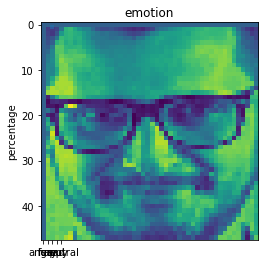

Happy
36


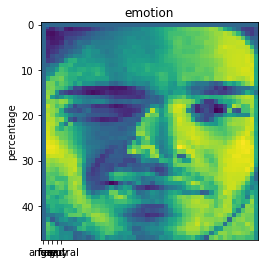

Fear
36


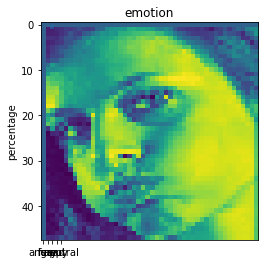

Happy
36


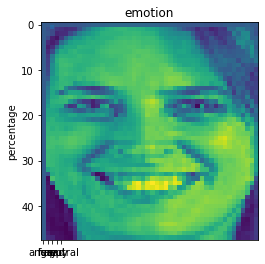

Happy
36


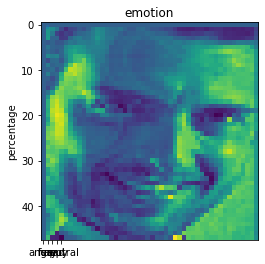

Fear
36


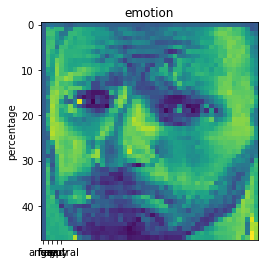

Happy
36


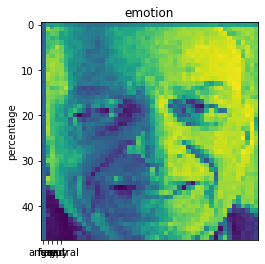

Happy
36


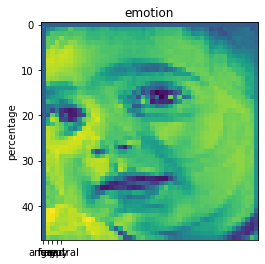

Angry
36


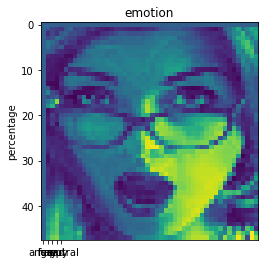

Fear
36


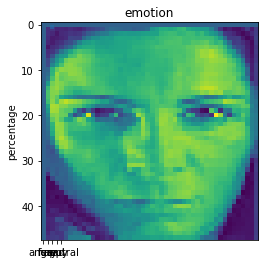

Happy
36


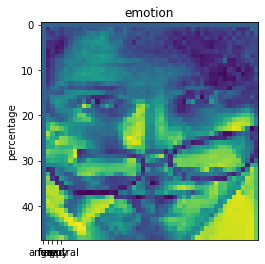

Happy
36


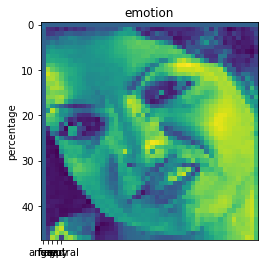

Angry
36


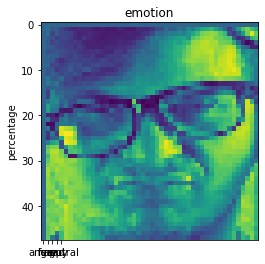

Fear
36


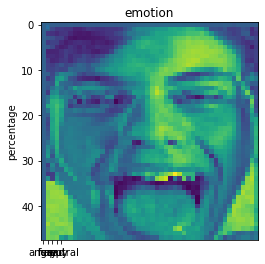

Fear
36


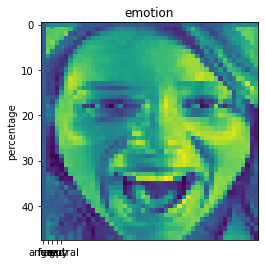

Happy
36


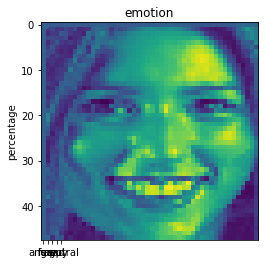

Fear
36


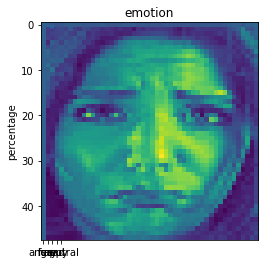

Happy
36


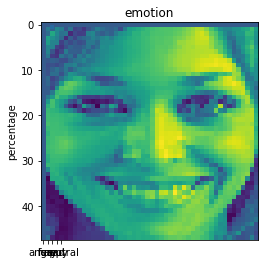

Happy
36


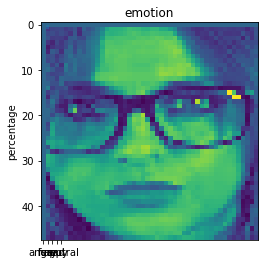

Fear
36


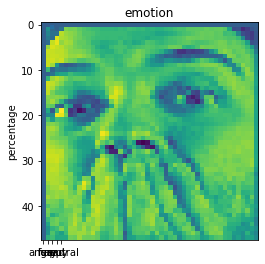

Happy
36


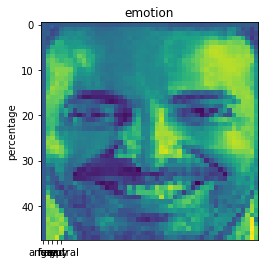

Happy
36


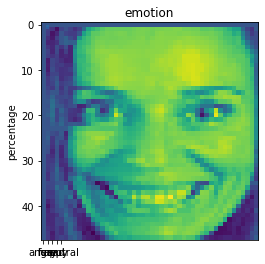

Fear
36


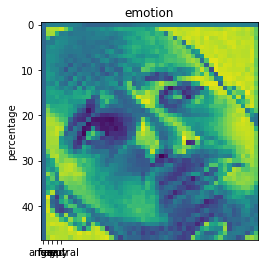

Angry
36


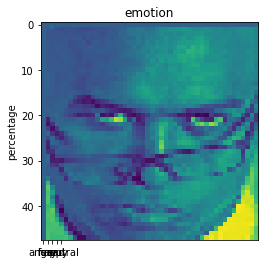

Happy
36


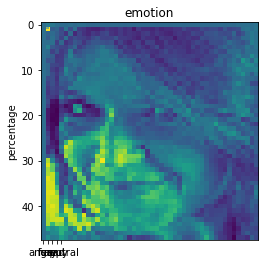

Fear
36


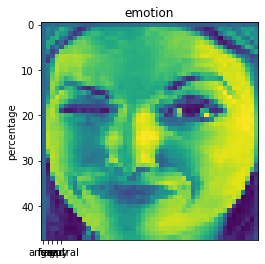

Fear
36


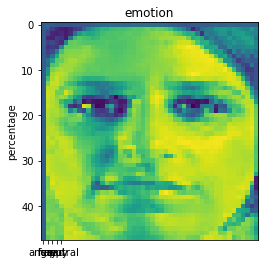

Fear


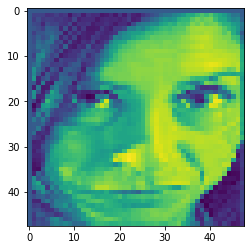

In [29]:
file= '/content/diff2.jpg'
faces_list=facecrop(file)
faces = np.array(faces_list)

#for i in range(len(faces_list)):
#  plt.imshow(faces[i])
# plt.show()


label_dict = {0:'Angry',1:'Fear',2:'Happy',3:'Sad',4:'Neutral'}




true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))





for i in range(len(faces_list)):
  x = np.expand_dims(faces[i], axis = 0)
  print(len(faces_list))
  custom = emotion_model.predict(x)
  emotion_analysis(custom[0])

  custom = list(custom[0])

  emotion_index = custom.index(max(custom))
  print(label_dict[emotion_index])


  x = np.array(x, 'float32')
  x = x.reshape([48, 48]);


  plt.imshow(faces[i])
plt.show()